In [49]:
from Utility05_Bayesian import *
# from bayes_opt import BayesianOptimization
from tiramisu_net import *
import scipy.io
import cv2
import multiprocessing
from OsUtils import *
import tensorflow as tf

Load data

In [50]:
import scipy.io
import cv2
import tensorflow as tf

In [51]:
n_MoteCarlo_Samples=20
def Monty_Model_softmax_X(X,model, N_MCS):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        SoftMaxBin_list.append(model.predict(X))
    SoftMaxBin=np.array(SoftMaxBin_list)
    
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)

    return SoftmaxMean,SoftmaxStd

In [52]:
from meta_info import *
N_MCS=1

In [53]:
MFW_data=np.load(cd_str+'ZL_dataset/'+str(new_H)+'x'+str(new_W)+'_'+data_type+'_MFW_data.npz')

pixel_unique=MFW_data['pixel_unique']
pixel_count=MFW_data['pixel_count']
class_weights_freq=MFW_data['class_weights_freq']

print('pixel_unique:')
print(pixel_unique)

print('pixel_count:')
pixel_count[1]=sum(pixel_count[1:])
pixel_count=pixel_count[0:5]
print(pixel_count)
pixel_med=np.median(pixel_count)
class_weights_freq=pixel_med/pixel_count

class_weights_freq=class_weights_freq*0+1
print('class_weights_freq:')
print(class_weights_freq)

Big_data_dictionary=load_pickle(cd_str+'ZL_dataset/Big_data_dictionary')

pixel_unique:
[0. 1.]
pixel_count:
[13876459   523541]
class_weights_freq:
[1. 1.]


In [54]:
# this class only helps visualize the data and is not a generator
class ZL_data_split:
    
    def __init__(self,
                 data_split_dict,split_type,split_id,train_sp,
                 new_H=new_H,new_W=new_W):
        
        self.data_split_dict=data_split_dict
        self.split_id=split_id      # 'train', 'val', 'test'
        self.split_type=split_type  # 'tool', 'agent', 'setup', 'random'
        self.new_H = new_H
        self.new_W = new_W        
        
        self.split_key=self.split_id+'_indx_bin'
        self.vid_frm_id_bin=self.data_split_dict[self.split_type][self.split_key]
        
        self.n_obs = len(self.vid_frm_id_bin)
        self.n_first=0
        self.n_last=self.n_obs
        
        if self.split_id=='train':
            if train_sp=='sp1':
                self.n_first=0
                self.n_last=int(len(self.vid_frm_id_bin)/2)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last])                
            elif train_sp=='sp2':
                self.n_first=int(len(self.vid_frm_id_bin)/2)
                self.n_last=len(self.vid_frm_id_bin)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last]) 
            elif train_sp=='all':
                pass
            else:
                print('invalid sp')
    
    def load_data(self,image_id, resize=True,verbose=0,
                  norm_RGB=255):
        
        split_key=self.split_id+'_indx_bin'
        vid_frm_id_bin=self.data_split_dict[self.split_type][split_key][image_id]
        
        data_tmp=np.load(cd_str+'ZL_dataset/proc_'+str(self.new_H)+'x'+str(self.new_W)\
                                                    +'/'+vid_frm_id_bin+'.npz')
        img_i=data_tmp['X']/norm_RGB
        mask_i=data_tmp['Y']

#         if resize:
#             mask_i = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
#             img_i = cv2.resize(np.array(img_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            
        if verbose==1:
            print('img_i.shape:  '+str(img_i.shape))
            print('mask_i.shape: '+str(mask_i.shape))
            
        return mask_i,img_i    

In [55]:
training_set=ZL_data_split(Big_data_dictionary,data_type,'train','all',new_W=new_W,new_H=new_H)
val_set=ZL_data_split(Big_data_dictionary,data_type,'val','none',new_W=new_W,new_H=new_H)
test_set=ZL_data_split(Big_data_dictionary,data_type,'test','none',new_W=new_W,new_H=new_H)

In [56]:
class DataGenerator_B(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, class_weights, batch_size,
                 data_split_dict,split_type,split_id,train_sp,
                 n_classes=2, shuffle=True, new_H=new_H, new_W=new_W):
        'Initialization'
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.n_classes = n_classes
        self.data_split_dict=data_split_dict
        self.split_type=split_type
        self.split_id=split_id
        self.train_sp=train_sp
        self.shuffle = shuffle
        self.new_H = new_H
        self.new_W = new_W      
        self.set_dir='SRG_'+self.split_id+'/'

        self.split_key=self.split_id+'_indx_bin'
        self.vid_frm_id_bin=self.data_split_dict[self.split_type][self.split_key]
        self.n_obs = len(self.vid_frm_id_bin)
        self.n_first=0
        self.n_last=self.n_obs
        
        if self.split_id=='train':
            if train_sp=='sp1':
                self.n_first=0
                self.n_last=int(len(self.vid_frm_id_bin)/2)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last])                
            elif train_sp=='sp2':
                self.n_first=int(len(self.vid_frm_id_bin)/2)
                self.n_last=len(self.vid_frm_id_bin)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last]) 
            elif train_sp=='all':
                pass
            else:
                print('invalid sp')       
        
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_obs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        data_tuple = self.__data_generation(indexes)

        return data_tuple

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_first,self.n_last,1) # only train on the first half of training set
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_size_auto=indexes.shape[0]
        X = np.empty((batch_size_auto, self.new_H,self.new_W, 8))
        y = np.empty((batch_size_auto, self.new_H,self.new_W), dtype=int)
        batch_weights = np.empty((batch_size_auto, self.new_H*self.new_W))

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            vid_frm_id=self.vid_frm_id_bin[ID]
            X[i,] = np.load(self.set_dir+'X_SRG_'+vid_frm_id+'.npz')['X_SRG'] # already normalized
            # Store class
            data_tmp=np.load(cd_str+'ZL_dataset/proc_'+str(self.new_H)+'x'+str(self.new_W)\
                                                        +'/'+vid_frm_id+'.npz')
            y[i]=data_tmp['Y']     
            
            avg_std=np.mean(X[i,:,:,5:7],axis=-1) # avg of softmax stds
            RLmat=avg_std+X[i,:,:,7]        # add entropy
            RLC=200
                                 
            batch_weights[i,]=np.reshape(RLmat,(1,new_H*self.new_W))*RLC
             
        #y[y>1]=1
        y_resh=y.reshape((-1,self.new_H*self.new_W))
#         print(np.amax(y_resh))
#         print(y_resh.shape)
        y_cat=tf.keras.utils.to_categorical(y_resh, num_classes=self.n_classes)
#         batch_wieghts = gen_weight_mat(y,self.class_weights)
#         print(batch_wieghts.shape)
        return (X, y_cat,batch_weights)

## SRG Model

In [57]:
n_epoch = 60
patience =10

batch_size_train = 1
batch_size_eval = 20
L2_C=0

input_shape=(new_H,new_W,8)

model_filename_save = 'SRG_MW.h5'

In [58]:
MFW_data=np.load(cd_str+'ZL_dataset/'+str(new_H)+'x'+str(new_W)+'_'+data_type+'_MFW_data.npz')

pixel_unique=MFW_data['pixel_unique']
pixel_count=MFW_data['pixel_count']
class_weights_freq=MFW_data['class_weights_freq']

print('pixel_unique:')
print(pixel_unique)

print('pixel_count:')
pixel_count[1]=sum(pixel_count[1:])
pixel_count=pixel_count[0:5]
print(pixel_count)
pixel_med=np.median(pixel_count)
class_weights_freq=pixel_med/pixel_count

class_weights_freq=class_weights_freq*0+1
print('class_weights_freq:')
print(class_weights_freq)

Big_data_dictionary=load_pickle(cd_str+'ZL_dataset/Big_data_dictionary')

pixel_unique:
[0. 1.]
pixel_count:
[13876459   523541]
class_weights_freq:
[1. 1.]


In [59]:
train_generator_sp_all = DataGenerator_B(
                                    class_weights_freq,batch_size_train,                 
                                    Big_data_dictionary,data_type,'train','all',
                                    new_W=new_W,new_H=new_H)
val_generator = DataGenerator_B(
                              class_weights_freq,batch_size_eval,
                              Big_data_dictionary,data_type,'val','none',
                              new_W=new_W,new_H=new_H,
                              shuffle=False)
test_generator = DataGenerator_B(
                               class_weights_freq,batch_size_eval,
                               Big_data_dictionary,data_type,'test','none',
                               new_W=new_W,new_H=new_H,
                               shuffle=False)

In [60]:
# SRG_model=Tiramisu(L2_C,
#                    input_shape=input_shape,
#                    n_classes = 2,
#                    n_filters_first_conv = 32,
#                    n_pool = 2,
#                    growth_rate = 16 ,
#                    n_layers_per_block = [3,3,4,3,3],
#                    dropout_p = 0.0)

In [61]:
# optimizer=optimizers.Nadam(learning_rate=1e-3, schedule_decay=0.004) 

In [62]:
# SRG_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"],sample_weight_mode="temporal")
# # "categorical_crossentropy"
# model_callbacks = [EarlyStopping(monitor='val_acc', patience=patience),
#          ModelCheckpoint(filepath=model_filename_save, monitor='val_acc', save_best_only=True,mode='max'), plot_losses] #bval_object #plot_losses

In [63]:
# model_hist = SRG_model.fit_generator(
#                                     train_generator_sp_all,
#                                     epochs=n_epoch,
#                                     callbacks=model_callbacks,
#                                     validation_data=val_generator,
#                                     max_queue_size=60,
#                                     verbose=1,  
#                                     workers = 8
#                                     )
# #                                     workers=4, #multiprocessing.cpu_count()
# #                                     use_multiprocessing=True,

In [64]:
best_model=load_model(model_filename_save)

In [65]:
def Monty_Model_softmax(data_generator, model, N_MCS=N_MCS,steps=100):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        print(i)
        SoftMaxBin_list.append(model.predict(data_generator))
    SoftMaxBin=np.array(SoftMaxBin_list)
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)
    return SoftmaxMean,SoftmaxStd

In [66]:
SoftmaxMean_test,SoftmaxStd_test = Monty_Model_softmax(test_generator,best_model, N_MCS=N_MCS,steps=test_generator.n_obs/batch_size_eval)

0


In [67]:
def get_Y(set_object):

    n_obs=set_object.n_obs
    y=np.empty((set_object.n_obs, new_H,new_W), dtype=int)
    for i_obs in range(set_object.n_obs):
        mask_i,_ = set_object.load_data(i_obs,verbose=0,resize=True)
        y[i_obs] = mask_i

#    y[y>1]=1
#     y_resh=y.reshape((-1,new_H*new_W))
    print(y.shape)
    return y

In [68]:
y_gt_test=get_Y(test_set)

(289, 180, 320)


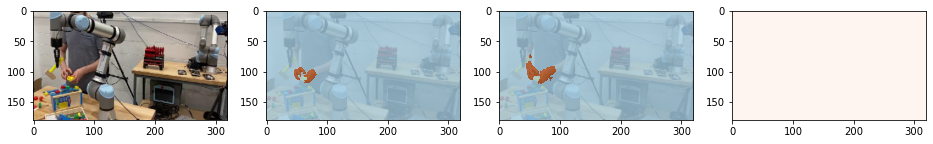

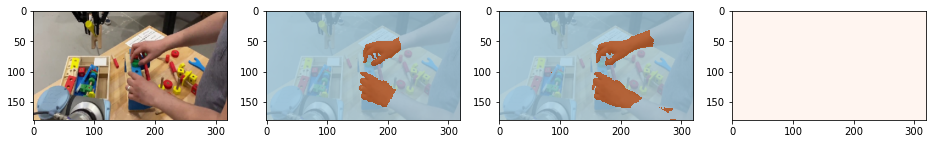

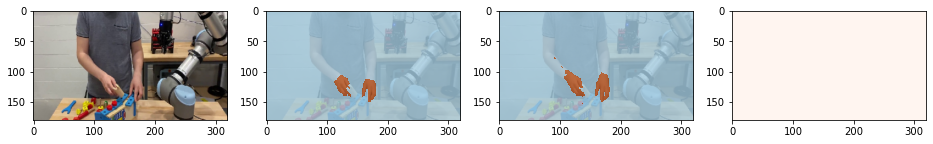

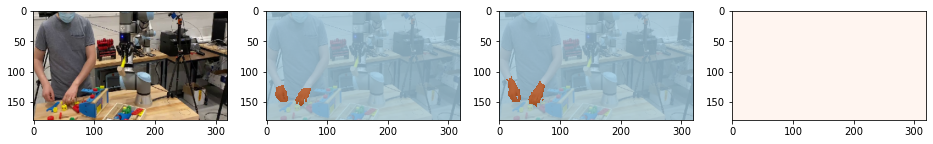

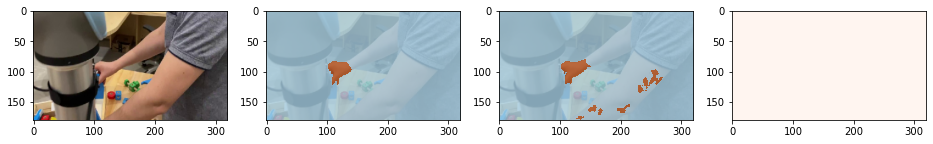

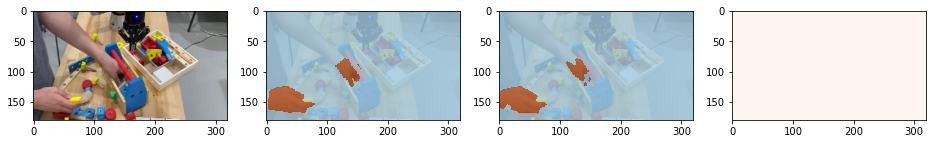

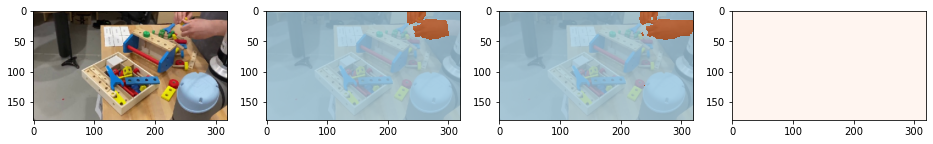

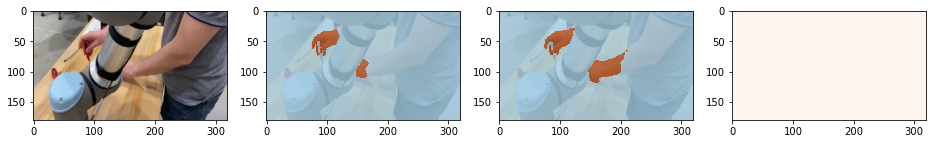

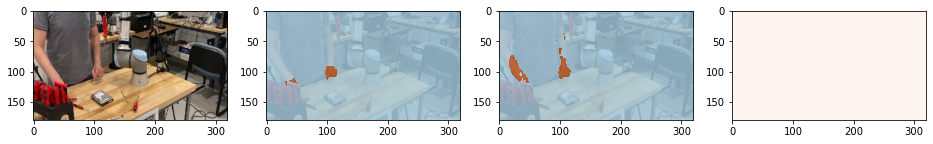

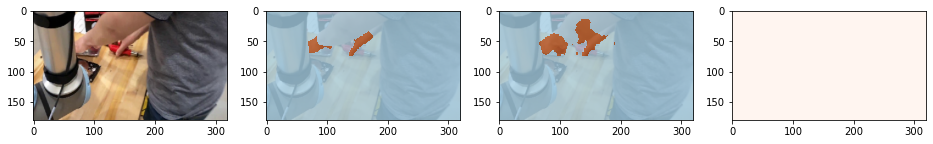

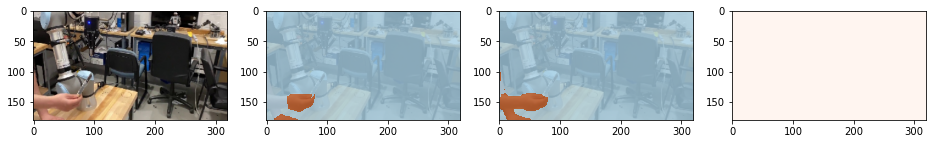

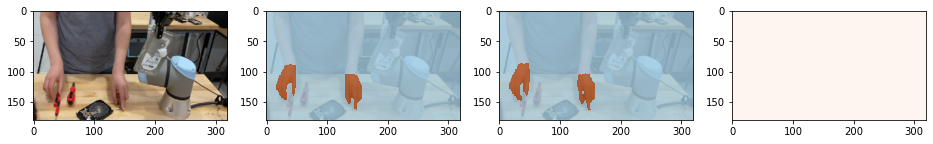

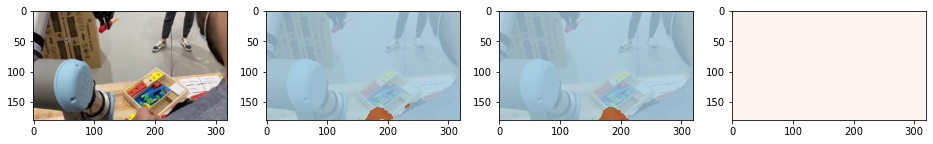

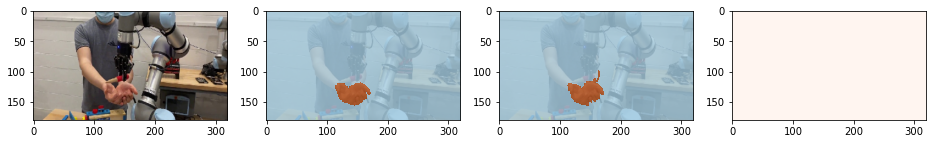

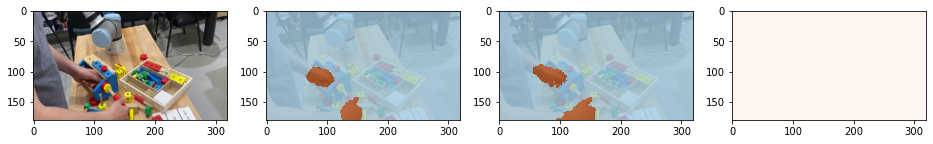

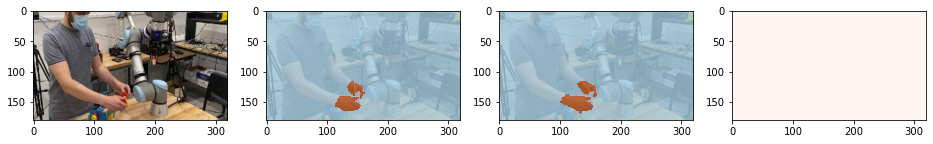

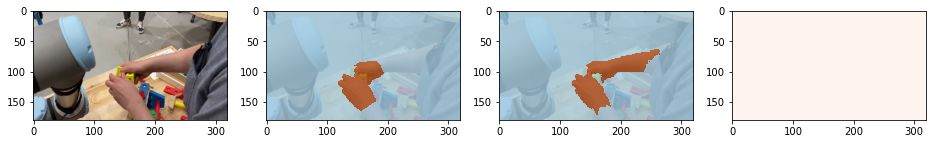

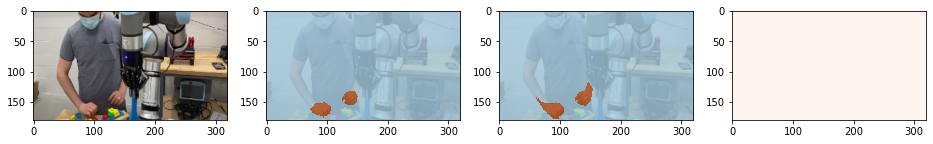

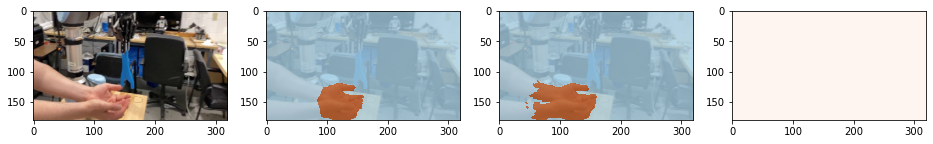

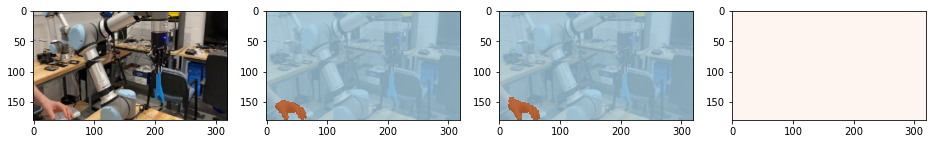

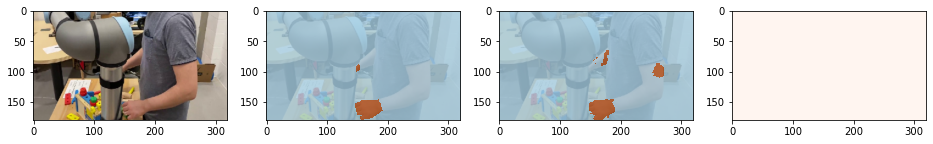

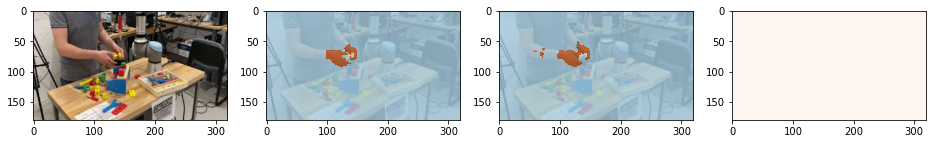

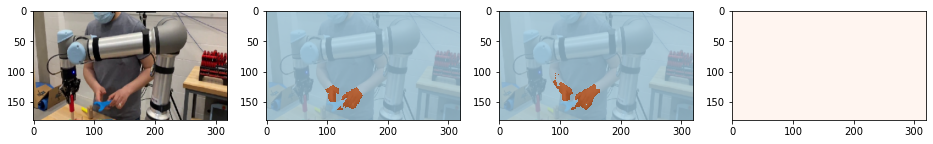

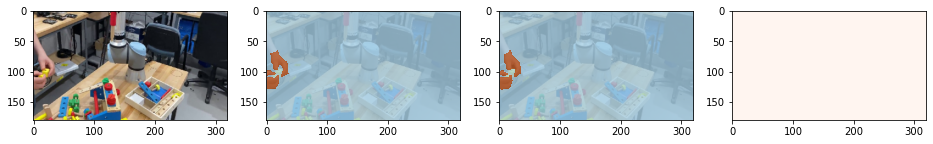

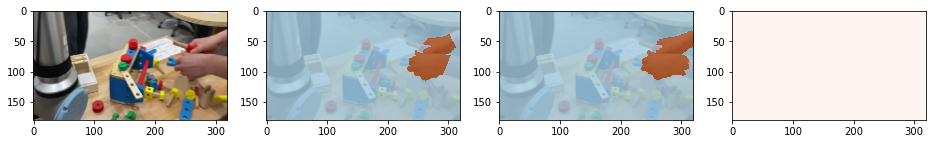

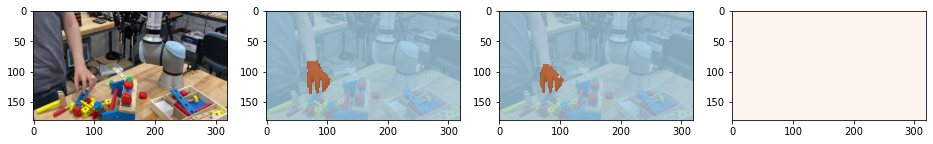

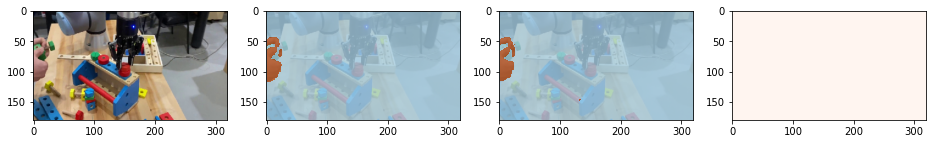

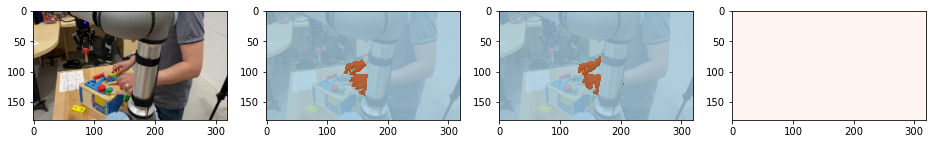

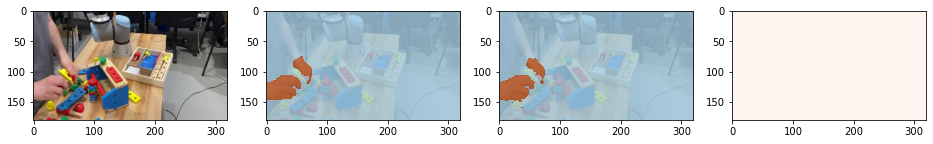

In [69]:
import matplotlib.colors as colors

for i_obs in np.arange(0,test_generator.n_obs,10):
    obs_id_eval=i_obs

    mask_i,img_i = test_set.load_data(obs_id_eval,verbose=0,resize=True)

    mask_pred_i=np.argmax(SoftmaxMean_test[obs_id_eval],axis=-1).reshape(new_H,new_W)
    mask_std_i=np.mean(SoftmaxStd_test[obs_id_eval],axis=-1).reshape(new_H,new_W)

    mask_i=mask_i
#     mask_i[mask_i!=4]=0
    fig, ax = plt.subplots(1,4,figsize=(16,5))
    ax[0].imshow(img_i)
    ax[1].imshow(img_i)
    im1=ax[1].imshow(mask_i,cmap='Paired',vmin=0,vmax=1,alpha=0.8,interpolation='nearest')
    ax[2].imshow(img_i)
    ax[2].imshow(mask_pred_i,cmap='Paired',vmin=0,vmax=1,alpha=0.8,interpolation='nearest')
    
    ax[3].imshow(mask_std_i,cmap='Reds')
    
#     fig.colorbar(im1, ax=ax)
    plt.show()
    plt.close()

In [70]:
def Models_eval_hands_B(SoftmaxMean,y_get_set,save_fname):
    
    Y_pred=np.argmax(SoftmaxMean,axis=-1).reshape(-1,new_H,new_W)
    # precision, recall, f1
    prc_bin, rec_bin, f1_bin, _ =precision_recall_fscore_support(y_get_set.ravel(), Y_pred.ravel())
    # calculate entropy
    p_c=SoftmaxMean
    max_p=np.sum(SoftmaxMean,axis=-1)
    max_p=np.reshape(max_p,max_p.shape+(1,))
    p_c_norm=np.divide(p_c,max_p)
    log_p_c=np.log10(p_c_norm+1e-12)
    entropy=np.sum(np.multiply(-1*p_c_norm,log_p_c),axis=-1)
    
    # IoU
    classes=np.unique(y_get_set)
    nClasses=len(classes)
    IoU_bin=[]

    Mask_GT=y_get_set
    Mask_Prd=Y_pred

    for i in range(nClasses):
        
        GT_class_cond=(Mask_GT==classes[i])
        Prd_class_cond=(Mask_Prd==classes[i])
        # Measure IoU
        intersection=np.logical_and(GT_class_cond,Prd_class_cond)
        union=np.logical_or(GT_class_cond,Prd_class_cond)
        
        IoU_class = np.sum(intersection) / np.sum(union) 
        IoU_bin.append(IoU_class)    
    
    print('           Background    Hands       mean')
    print('Precision:    %1.2f      %1.2f      %1.2f'%(prc_bin[0]*100,
                                                     prc_bin[1]*100,
                                                     np.mean(prc_bin)*100))
    
    print('Recall:       %1.2f      %1.2f      %1.2f'%(rec_bin[0]*100,
                                                     rec_bin[1]*100,
                                                     np.mean(rec_bin)*100))
     
    print('F1-score:     %1.2f      %1.2f      %1.2f'%(f1_bin[0]*100,
                                                     f1_bin[1]*100,
                                                     np.mean(f1_bin)*100))
    
    print('IoU:          %1.2f      %1.2f      %1.2f'%(IoU_bin[0]*100,
                                                     IoU_bin[1]*100,
                                                     np.mean(IoU_bin)*100))
            
    # save to file 
    np.savez_compressed(save_fname+'.npz',prc_bin=prc_bin, rec_bin=rec_bin, f1_bin=f1_bin, IoU_bin=IoU_bin)
    

In [71]:
Models_eval_hands_B(SoftmaxMean_test,y_gt_test,'test_metrics_SRG')

           Background    Hands       mean
Precision:    99.79      74.86      87.32
Recall:       99.06      93.06      96.06
F1-score:     99.42      82.97      91.20
IoU:          98.86      70.90      84.88


In [ ]:
# 3
#            Background    Hands       mean
# Precision:    99.79      74.86      87.32
# Recall:       99.06      93.06      96.06
# F1-score:     99.42      82.97      91.20
# IoU:          98.86      70.90      84.88

In [72]:
# 5
#            Background    Hands       mean
# Precision:    99.79      75.27      87.53
# Recall:       99.08      93.08      96.08
# F1-score:     99.44      83.23      91.33
# IoU:          98.88      71.28      85.08

In [73]:
# 10
#            Background    Hands       mean
# Precision:    99.79      75.70      87.75
# Recall:       99.10      93.10      96.10
# F1-score:     99.45      83.50      91.47
# IoU:          98.90      71.68      85.29